In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Define the file path
file_path = '/scratch/harvard/abaraban/df_merged.csv'

# Read the DataFrame from the CSV file
dtype_spec = {
    'crsp_obj_cd': 'string',
    'si_obj_cd': 'string',
    'wbrger_obj_cd': 'string',
    'policy': 'string',
    'lipper_asset_cd': 'string',
    'lipper_class': 'string',
    'lipper_obj_cd': 'string'
}
df_merged = pd.read_csv(file_path, dtype=dtype_spec)

# Exclude rows where 'crsp_obj_cd' starts with 'I' or 'O'
excludes_i_o = ~df_merged['crsp_obj_cd'].str.startswith(('OM', 'OC', 'I'), na=False)

# Create a new DataFrame excluding the specified 'crsp_obj_cd' codes
df_merged = df_merged[excludes_i_o]
print(df_merged.shape)

# List of substrings to check for
# Appel et al 2016
substrings = [
    'Index', 'Idx', 'Indx', 'Ind', 'Russell', 'S & P', 'S and P', 'S&P', 'SandP', 'SP',
    'DOW', 'Dow', 'DJ', 'MSCI', 'Bloomberg', 'KBW', 'NASDAQ', 'NYSE', 'STOXX',
    'FTSE', 'Wilshire', 'Morningstar', '100', '400', '500', '600', '900', '1000',
    '1500', '2000', '5000'
]
print(df_merged.shape)
# Create the 'index' column
df_merged['index'] = df_merged['fund_name'].str.contains('|'.join(substrings), case=False).astype(int)


# df_merged = df_merged[~((df_merged['index_fund_flag'] == 'D') | (df_merged['index'] == 1))]

conditions_active = (
    (df_merged['index_fund_flag'].isin(['B', 'E'])) &
    (df_merged['index'] == 0)
)

conditions_passive = (
    (df_merged['index_fund_flag'] == 'D') |
    (df_merged['index'] == 1)
)

# Initialize fund type to 'Other', then set to 'Active' or 'Passive' based on conditions
df_merged['fund_type'] = 'Other'
df_merged.loc[conditions_active, 'fund_type'] = 'Active'
df_merged.loc[conditions_passive, 'fund_type'] = 'Passive'

# Split the DataFrame into active, passive, and other
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']

# Display the results
print("Active Funds:")
print(active_funds.shape)

print("\nPassive Funds:")
print(passive_funds.shape)

# There are no other Funds

(4133743, 64)
(4133743, 64)
Active Funds:
(1148002, 66)

Passive Funds:
(2985741, 66)


/tmp/23396428.1.jupyterhub.q/ipykernel_3437333/2992633852.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  value_added_2nd_half = df_merged.groupby('crsp_fundno').apply(calculate_second_half_avg).reset_index()
/tmp/23396428.1.jupyterhub.q/ipykernel_3437333/2992633852.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  value_added_2nd_half = df_merged.groupby('crsp_fundno').apply(calculate_second_half_avg).reset_index()


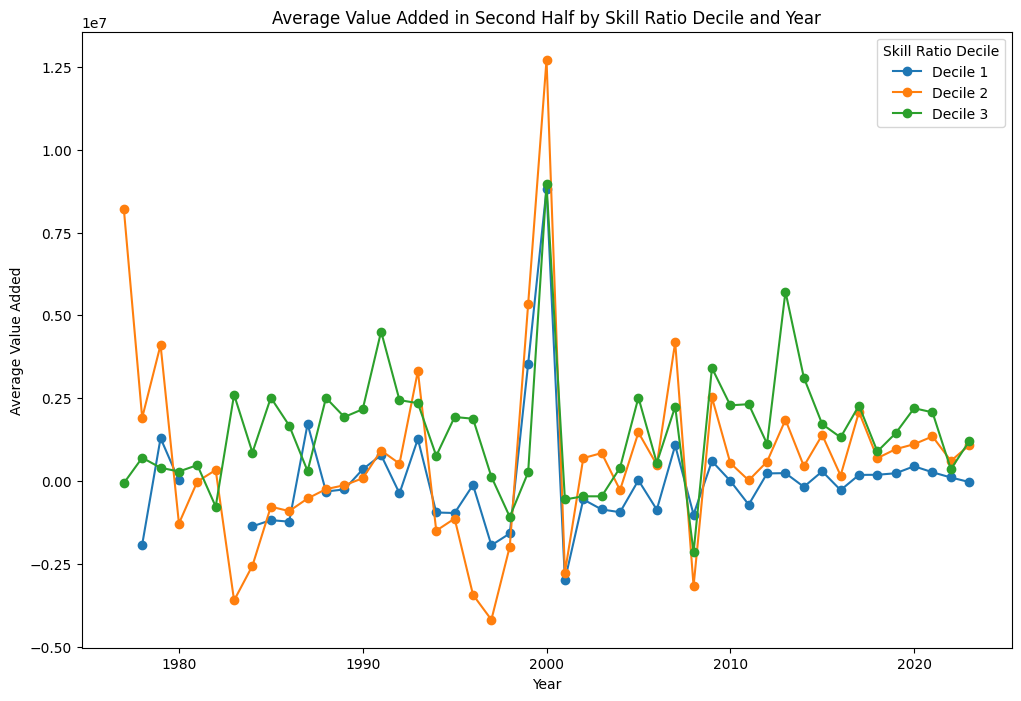

In [2]:
# Calculate average value added in the second half of the observations by year
df_merged['caldt'] = pd.to_datetime(df_merged['caldt'])

def calculate_second_half_avg(group):
    n = len(group)
    half_n = n // 2
    if half_n > 1:
        second_half = group.iloc[half_n:]
        return second_half.groupby(second_half['caldt'].dt.year)['vanguard_VA'].mean()
    else:
        return pd.Series()

value_added_2nd_half = df_merged.groupby('crsp_fundno').apply(calculate_second_half_avg).reset_index()

# Rename columns for merging
value_added_2nd_half.columns = ['crsp_fundno', 'year', 'avg_value_added_2nd_half']

# Merge the average value added by year to the main DataFrame
df_merged = df_merged.merge(value_added_2nd_half, on=['crsp_fundno', 'year'], how='left')

df_merged = df_merged.dropna(subset=['skill_ratio'])

# Now decile on skill ratio
deciles = pd.qcut(df_merged['skill_ratio'], 3, labels=False)
df_merged['skill_ratio_decile'] = deciles

# Group by year and decile and calculate the mean avg_value_added_2nd_half
decile_yearly_avg_value_added = df_merged.groupby(['year', 'skill_ratio_decile'])['avg_value_added_2nd_half'].mean().unstack()

# Plot the results
plt.figure(figsize=(12, 8))
for decile in decile_yearly_avg_value_added.columns:
    plt.plot(decile_yearly_avg_value_added.index, decile_yearly_avg_value_added[decile], marker='o', label=f'Decile {decile + 1}')

plt.title('Average Value Added in Second Half by Skill Ratio Decile and Year')
plt.xlabel('Year')
plt.ylabel('Average Value Added')
plt.legend(title='Skill Ratio Decile')
plt.grid(False)
plt.show()

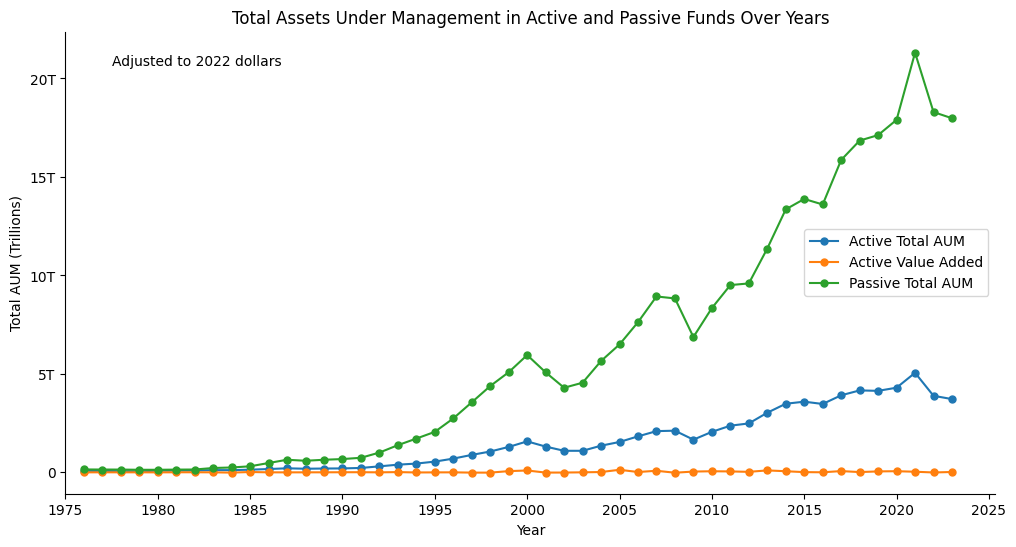

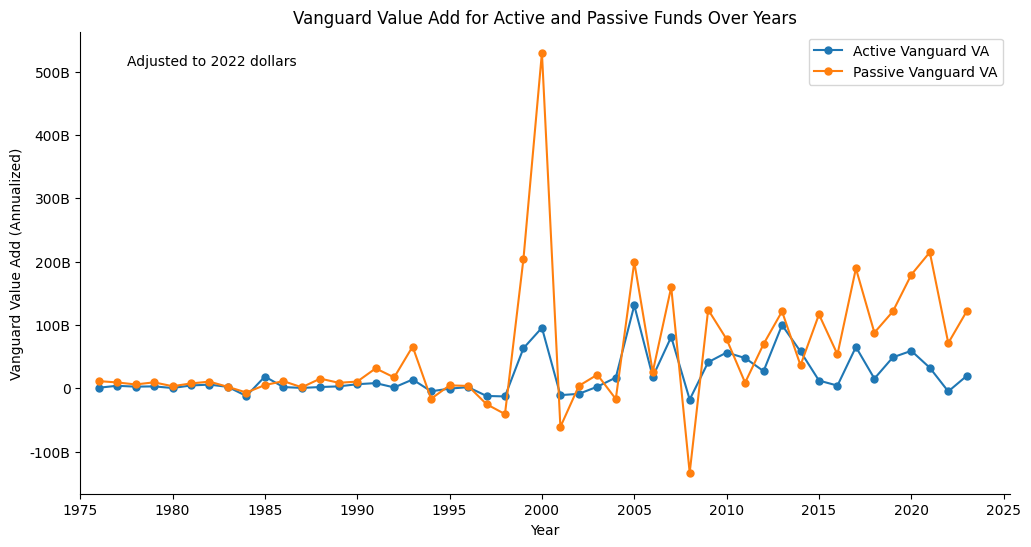

In [3]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Assuming df_merged is already created, read, and processed as described in your previous steps.

# Separate the data into active and passive funds
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']

# Calculate metrics for active funds
num_active_funds = active_funds.groupby('year')['crsp_fundno'].nunique()
mean_active_assets_per_fund = active_funds.groupby('year')['mtna_adj2022'].mean()
active_ff_VA = active_funds.groupby('year')['ff_VA'].mean()
active_vanguard_VA = active_funds.groupby('year')['vanguard_VA'].mean()

active_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_active_funds,
    'mean_assets_per_fund': mean_active_assets_per_fund,
    'ff_monthly_mean_VA': active_ff_VA,
    'vanguard_monthly_mean_VA': active_vanguard_VA
}).reset_index()

active_df_by_year['total_aum_in_funds'] = active_df_by_year['num_funds_each_year'] * active_df_by_year['mean_assets_per_fund'] * 1000000
active_df_by_year['ff_VA_tot'] = active_df_by_year['ff_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']
active_df_by_year['vanguard_VA_tot'] = active_df_by_year['vanguard_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']

# Calculate metrics for passive funds
num_passive_funds = passive_funds.groupby('year')['crsp_fundno'].nunique()
mean_passive_assets_per_fund = passive_funds.groupby('year')['mtna_adj2022'].mean()
passive_ff_VA = passive_funds.groupby('year')['ff_VA'].mean()
passive_vanguard_VA = passive_funds.groupby('year')['vanguard_VA'].mean()

passive_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_passive_funds,
    'mean_assets_per_fund': mean_passive_assets_per_fund,
    'ff_monthly_mean_VA': passive_ff_VA,
    'vanguard_monthly_mean_VA': passive_vanguard_VA
}).reset_index()

passive_df_by_year['total_aum_in_funds'] = passive_df_by_year['num_funds_each_year'] * passive_df_by_year['mean_assets_per_fund'] * 1000000
passive_df_by_year['ff_VA_tot'] = passive_df_by_year['ff_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']
passive_df_by_year['vanguard_VA_tot'] = passive_df_by_year['vanguard_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']

# Define billions and trillions formatters
def billions(x, pos):
    if x == 0:
        return '0'
    return f'{x * 1e-9:.0f}B'  # convert to billions

def trillions(x, pos):
    if x == 0:
        return '0'
    else:
        return f'{x * 1e-12:.0f}T'

# Create formatter
formatter = FuncFormatter(trillions)

# Plot AUM for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Active Total AUM")
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Value Added")

plt.plot(passive_df_by_year['year'], passive_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Passive Total AUM")

plt.title('Total Assets Under Management in Active and Passive Funds Over Years')
plt.xlabel('Year')
plt.ylabel('Total AUM (Trillions)')
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter
plt.text(0.05, 0.95, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=None)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_aum.pdf')
plt.show()
formatter = FuncFormatter(billions)

# Plot Vanguard Value Add for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Vanguard VA")
plt.plot(passive_df_by_year['year'], passive_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Passive Vanguard VA")

plt.title('Vanguard Value Add for Active and Passive Funds Over Years')
plt.xlabel('Year')
plt.ylabel('Vanguard Value Add (Annualized)')
plt.text(0.05, 0.95, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=None)
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_vanguard_va.pdf')
plt.show()

In [4]:
"""df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)

# Define a function to compute the skill ratio for the first 50% observations of each fund
def compute_skill_ratio(group):
    n = len(group)
    half_n = n // 2  # Get the first 50% of the observations
    
    # Ensure there are enough observations to compute the ratio
    if half_n > 1:
        first_half = group.iloc[:half_n]
        mean_vanguard_VA = first_half['vanguard_VA'].mean()
        std_vanguard_VA = first_half['vanguard_VA'].std()
        
        if std_vanguard_VA != 0:
            skill_ratio = mean_vanguard_VA / std_vanguard_VA
        else:
            print(group)
            skill_ratio = np.nan

        return pd.Series({'skill_ratio': skill_ratio})
    else:
        return pd.Series({'skill_ratio': np.nan})

# Group the DataFrame by crsp_fundno and apply the skill ratio computation
skill_ratios = df_merged.groupby('crsp_fundno').apply(compute_skill_ratio).reset_index()

# Merge the skill ratios back to the original DataFrame
df_merged = df_merged.merge(skill_ratios, on='crsp_fundno', how='left')

SyntaxError: incomplete input (2012282952.py, line 1)

In [ ]:
"""df_merged[~df_merged['skill_ratio'].isna()]

In [5]:
active_df_by_year

,year,num_funds_each_year,mean_assets_per_fund,ff_monthly_mean_VA,vanguard_monthly_mean_VA,total_aum_in_funds,ff_VA_tot,vanguard_VA_tot
0,1976,129,595.734147,8.851042e+05,5.606018e+05,7.684970e+10,1.370141e+09,8.678116e+08
1,1977,134,525.159657,2.466564e+06,2.449287e+06,7.037139e+10,3.966234e+09,3.938453e+09
2,1978,138,440.370141,3.298858e+06,1.551768e+06,6.077108e+10,5.462908e+09,2.569727e+09
3,1979,128,411.095660,3.732009e+06,1.960502e+06,5.262024e+10,5.732366e+09,3.011331e+09
4,1980,135,628.618226,4.794473e+06,2.582736e+05,8.486346e+10,7.767046e+09,4.184032e+08
5,1981,131,692.180754,8.620978e+06,2.812419e+06,9.067568e+10,1.355218e+10,4.421123e+09
6,1982,135,700.183392,8.698840e+06,3.585875e+06,9.452476e+10,1.409212e+10,5.809117e+09
7,1983,162,709.683827,6.031716e+06,1.121830e+06,1.149688e+11,1.172566e+10,2.180838e+09
8,1984,168,671.447201,-5.079316e+05,-6.055525e+06,1.128031e+11,-1.023990e+09,-1.220794e+10
9,1985,195,701.141107,1.114905e+07,7.914288e+06,1.367225e+11,2.608878e+10,1.851943e+10
